import the libaries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Configuration Settings

In [2]:
DATA_DIR = "myData"
LABEL_FILE = 'labels.csv'
BATCH_SIZE = 50
TRAINING_STEPS = 2000
TOTAL_EPOCHS = 15
IMAGE_DIMENSIONS = (32, 32, 3)
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2

Data Loading and Processing

In [3]:
class_count = 0
image_data = []
class_labels = []
class_list = os.listdir(DATA_DIR)
total_classes = len(class_list)
print("Total Classes Detected:", total_classes)
print("Loading Dataset...")

for i in range(0, len(class_list)):
    current_class_images = os.listdir(DATA_DIR + "/" + str(class_count))
    for image_name in current_class_images:
        current_image = cv2.imread(DATA_DIR + "/" + str(class_count) + "/" + image_name)
        image_data.append(current_image)
        class_labels.append(class_count)
    print(class_count, end=" ")
    class_count += 1
print("\n")

image_data = np.array(image_data)
class_labels = np.array(class_labels)

Total Classes Detected: 4
Loading Dataset...
0 1 2 3 



Data Splitting

In [4]:

train_images, test_images, train_labels, test_labels = train_test_split(image_data, class_labels, test_size=TEST_SPLIT)
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=VALIDATION_SPLIT)

Data Verification

In [5]:

print("Dataset Dimensions:")
print("Training Set:", end=""); print(train_images.shape, train_labels.shape)
print("Validation Set:", end=""); print(valid_images.shape, valid_labels.shape)
print("Test Set:", end=""); print(test_images.shape, test_labels.shape)

# Verify data integrity
assert(train_images.shape[0] == train_labels.shape[0]), "Training set: Image and label count mismatch"
assert(valid_images.shape[0] == valid_labels.shape[0]), "Validation set: Image and label count mismatch"
assert(test_images.shape[0] == test_labels.shape[0]), "Test set: Image and label count mismatch"
assert(train_images.shape[1:] == (IMAGE_DIMENSIONS)), "Training images: Invalid dimensions"
assert(valid_images.shape[1:] == (IMAGE_DIMENSIONS)), "Validation images: Invalid dimensions"
assert(test_images.shape[1:] == (IMAGE_DIMENSIONS)), "Test images: Invalid dimensions"

Dataset Dimensions:
Training Set:(2080, 32, 32, 3) (2080,)
Validation Set:(520, 32, 32, 3) (520,)
Test Set:(650, 32, 32, 3) (650,)


Label Processing

In [6]:
label_data = pd.read_csv(LABEL_FILE)
print("Label data shape:", label_data.shape, type(label_data))

Label data shape: (4, 2) <class 'pandas.core.frame.DataFrame'>


Visualization

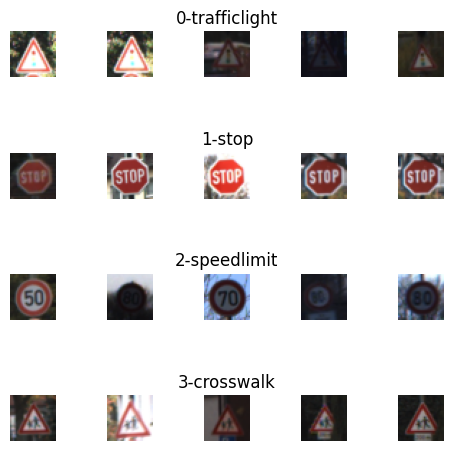

In [7]:
samples_per_class = []
preview_cols = 5
fig, axes = plt.subplots(nrows=total_classes, ncols=preview_cols, figsize=(5, 5))
fig.tight_layout()

for col in range(preview_cols):
    for idx, row in label_data.iterrows():
        class_samples = train_images[train_labels == idx]
        axes[idx][col].imshow(class_samples[random.randint(0, len(class_samples) - 1), :, :], cmap=plt.get_cmap("gray"))
        axes[idx][col].axis("off")
        if col == 2:
            axes[idx][col].set_title(str(idx) + "-" + row["Name"])
            samples_per_class.append(len(class_samples))

Distribution Visualization

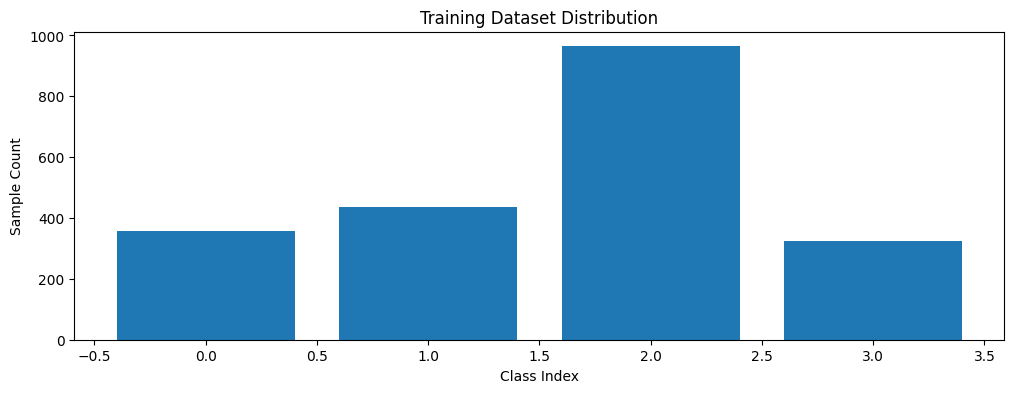

In [8]:
plt.figure(figsize=(12, 4))
plt.bar(range(0, total_classes), samples_per_class )
plt.title("Training Dataset Distribution")
plt.xlabel("Class Index")
plt.ylabel("Sample Count")
plt.show()

In [9]:

def convert_to_grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def histogram_equalization(img):
    return cv2.equalizeHist(img)

def preprocess_image(img):
    grayscaled = convert_to_grayscale(img)
    equalized = histogram_equalization(grayscaled)
    normalized = equalized / 255
    return normalized

train_images = np.array(list(map(preprocess_image, train_images)))
valid_images = np.array(list(map(preprocess_image, valid_images)))
test_images = np.array(list(map(preprocess_image, test_images)))

cv2.imshow("Preprocessed Sample", train_images[random.randint(0, len(train_images)-1)])

Dimension Adjustment

In [10]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
valid_images = valid_images.reshape(valid_images.shape[0], valid_images.shape[1], valid_images.shape[2], 1)
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1)

Data Augmentation

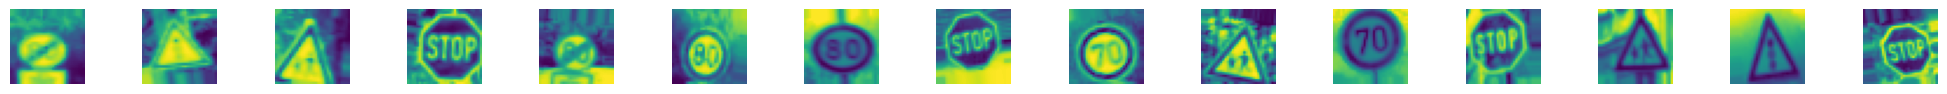

In [11]:
augmenter = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10
)

augmenter.fit(train_images)
augmented_batches = augmenter.flow(train_images, train_labels, batch_size=20)
augmented_images, augmented_labels = next(augmented_batches)

# Display augmented samples
fig, axes = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axes[i].imshow(augmented_images[i].reshape(IMAGE_DIMENSIONS[0], IMAGE_DIMENSIONS[1]))
    axes[i].axis('off')
plt.show()

Label Encoding

In [12]:
train_labels = to_categorical(train_labels, total_classes)
valid_labels = to_categorical(valid_labels, total_classes)
test_labels = to_categorical(test_labels, total_classes)

Model Architecture 

In [13]:

def create_model():
    filter_count = 60
    conv_filter_size = (5, 5)
    conv_filter_size_2 = (3, 3)
    pool_size = (2, 2)
    dense_layer_size = 500

    model = Sequential()
    
    # First Convolutional Block
    model.add((Conv2D(filter_count, conv_filter_size, 
                      input_shape=(IMAGE_DIMENSIONS[0], IMAGE_DIMENSIONS[1], 1), 
                      activation='relu')))
    model.add((Conv2D(filter_count, conv_filter_size, activation='relu')))
    model.add(MaxPooling2D(pool_size=pool_size))
    
    # Second Convolutional Block
    model.add((Conv2D(filter_count//2, conv_filter_size_2, activation='relu')))
    model.add((Conv2D(filter_count//2, conv_filter_size_2, activation='relu')))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))
    
    # Dense Layers
    model.add(Flatten())
    model.add(Dense(dense_layer_size, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(total_classes, activation='softmax'))
    
    # Compilation
    model.compile(Adam(learning_rate=0.001), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])
    return model

Model Training

In [14]:
model = create_model()
print(model.summary())

training_history = model.fit(
    augmenter.flow(train_images, train_labels, batch_size=BATCH_SIZE),
    steps_per_epoch=TRAINING_STEPS,
    epochs=TOTAL_EPOCHS,
    validation_data=(valid_images, valid_labels),
    shuffle=True
)

C:\Users\deema\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 60)          │          90,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 30)          │          16,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,004 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 358,484 (1.37 MB)

 Trainable params: 358,484 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\deema\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


None
Epoch 1/15
  42/2000 ━━━━━━━━━━━━━━━━━━━━ 1:57 60ms/step - accuracy: 0.4451 - loss: 1.2773

C:\Users\deema\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.4734 - loss: 1.2456 - val_accuracy: 0.6135 - val_loss: 0.9865
Epoch 2/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6683 - loss: 0.8192 - val_accuracy: 0.9154 - val_loss: 0.2398
Epoch 3/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8196 - loss: 0.4918 - val_accuracy: 0.9904 - val_loss: 0.0602
Epoch 4/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8959 - loss: 0.2915 - val_accuracy: 0.9923 - val_loss: 0.0274
Epoch 5/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9241 - loss: 0.2148 - val_accuracy: 1.0000 - val_loss: 0.0190
Epoch 6/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9467 - loss: 0.1607 - val_accuracy: 1.0000 - val_loss: 0.0106
Epoch 7/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9602 - loss: 0.1303 - val_accuracy: 0.9981 - val_loss: 0.0103
Epoch 8/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9649 - loss: 0.1115 - val_accurac

Performance Visualization

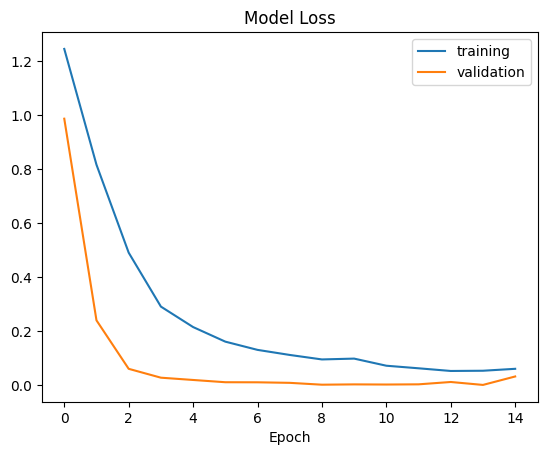

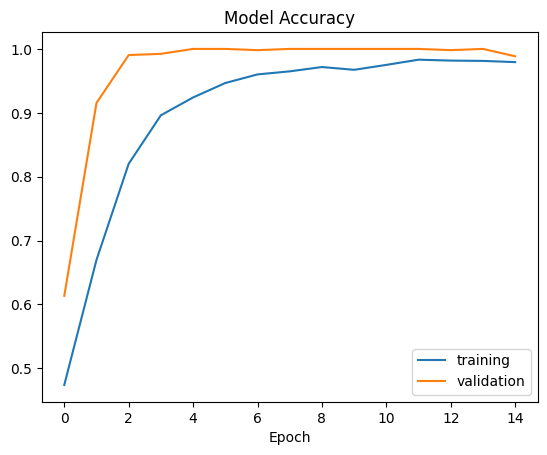

Test Loss: 0.03413976728916168
Test Accuracy: 0.9830769300460815


In [15]:
# Loss Plot
plt.figure(1)
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Model Loss')
plt.xlabel('Epoch')

# Accuracy Plot
plt.figure(2)
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.show()

# Evaluate Model
test_score = model.evaluate(test_images, test_labels, verbose=0)
print('Test Loss:', test_score[0])
print('Test Accuracy:', test_score[1])


Model Persistence

In [ ]:
model_file = open("model_trained.p", "wb")
pickle.dump(model, model_file)
model_file.close()
cv2.waitKey(0)